In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm_notebook, trange

In [0]:
BATCH_SIZE = 64

mnist_data = datasets.MNIST('./mnist', train=True, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))

data_loader = torch.utils.data.DataLoader(mnist_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=4)

In [0]:
class Generator(nn.Module):

  def __init__(self, in_size, out_size):
    super(Generator, self).__init__()

    self.fc1 = nn.Linear(in_size, 512)
    self.fc2 = nn.Linear(512, out_size)
  
  def forward(self, latent_vector):

    x = self.fc1(latent_vector)
    x = F.leaky_relu(x, negative_slope=0.2)
    x = self.fc2(x)
    x = F.leaky_relu(x, negative_slope=0.2)

    return x

In [0]:
class Discriminator(nn.Module):

  def __init__  (self, img_size):

    super(Discriminator, self).__init__()

    self.fc1 = nn.Linear(img_size, 512)
    self.fc2 = nn.Linear(512, 1)

  def forward(self, img):

    x = self.fc1(img)
    x = F.leaky_relu(x, negative_slope=0.2)
    x = self.fc2(x)
    x = torch.sigmoid(x)

    return x

In [0]:
x, y = next(iter(data_loader))

In [0]:
x.shape

torch.Size([64, 1, 28, 28])

In [0]:
IMG_SIZE = 28*28
LATENT_SIZE = 64
generator_model = Generator(LATENT_SIZE, IMG_SIZE).cuda()
discriminator_model = Discriminator(IMG_SIZE).cuda()

bce_loss = nn.BCELoss()

In [0]:
NUM_EPOCHS = 100

optimizer_G = torch.optim.Adam(generator_model.parameters(), lr = 1e-4)
optimizer_D = torch.optim.Adam(discriminator_model.parameters(), lr = 1e-4)

for epoch in tqdm_notebook(range(NUM_EPOCHS)):

  for x, _ in data_loader:

    current_batch_size = x.shape[0]
    real_images = x.view(current_batch_size, -1).cuda()

    batch_ones = torch.ones((current_batch_size, 1)).cuda()
    batch_zeros = torch.zeros((current_batch_size, 1)).cuda()

    # Generator Training

    latent_vals = torch.randn((current_batch_size, LATENT_SIZE)).cuda()
    # print(latent_vals.shape)
    generated_fakes = generator_model(latent_vals)
    discriminator_results_for_fakes = discriminator_model(generated_fakes)
    generator_loss = bce_loss(discriminator_results_for_fakes, batch_ones)

    optimizer_G.zero_grad()
    generator_loss.backward()
    optimizer_G.step()

    # Discriminator Training

    discriminator_results_for_true_imgs = discriminator_model(real_images)

    discriminator_results_for_fakes = discriminator_model(generated_fakes.detach())
    # We detach the generated_fakes because we are only training discriminator in this 
    # phase. detach() prevents the gradients from being propagated
    
    fake_loss = bce_loss(discriminator_results_for_fakes, batch_zeros)
    real_loss = bce_loss(discriminator_results_for_true_imgs, batch_ones)

    total_loss = fake_loss + real_loss

    optimizer_D.zero_grad()
    total_loss.backward()
    optimizer_D.step()

In [0]:
import matplotlib.pyplot as plt

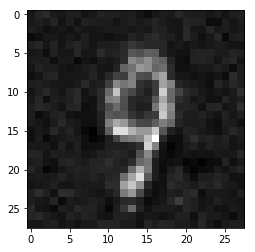

In [0]:
test_latent = torch.randn((1, LATENT_SIZE)).cuda()

test_gen_image = generator_model(test_latent)

test_gen_image = test_gen_image.view(28, 28)

numpy_img = test_gen_image.cpu().detach().numpy()

plt.imshow(numpy_img, cmap='gray')